# Plant Disease Detection

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt

In [2]:
filenames = [".\Train\Train_2.pgm",".\Train\Train_1.pgm",".\Train\Train_3.pgm",".\Train\Train_4.pgm"]
Train1 = cv.imread(filenames[0],0)
Train2 = cv.imread(filenames[1],0)
Train3 = cv.imread(filenames[2],0)
Train4 = cv.imread(filenames[3],0)

train_images = [Train1, Train2, Train3 ,Train4]

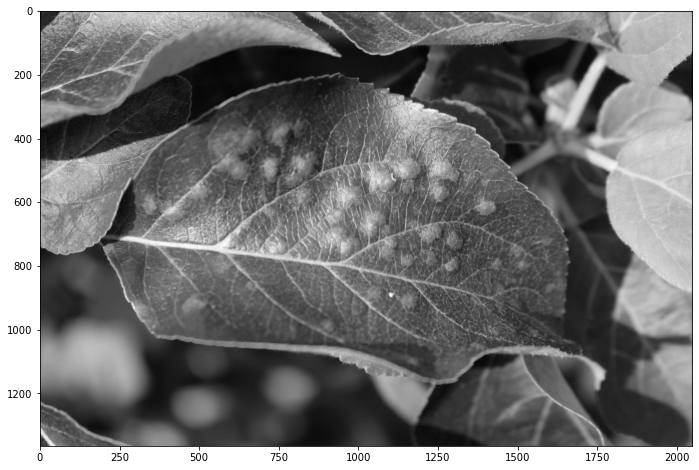

In [3]:
plt.figure(figsize = (13,8))    
plt.imshow(train_images[0],cmap = 'gray')
plt.show()

Detect when an image is Blurry:
https://www.youtube.com/watch?v=5YP7OoMhXbM

In [4]:
for i in range(len(train_images)):

    laplacian_var = cv.Laplacian(train_images[i],cv.CV_64F).var()
    print("Train image",i+1,":",laplacian_var)
    
    if laplacian_var < 5:
        print("Image is blurry")

Train image 1 : 88.3239493029376
Train image 2 : 92.54372310990715
Train image 3 : 71.43962136137067
Train image 4 : 238.29712458071185


In [5]:
# kernel = np.array([[-1,-1,-1], 
#                    [-1, 9,-1],
#                    [-1,-1,-1]])
# sharpened = cv.filter2D(train_images[0], -1, kernel)
# plt.figure(figsize = (13,8))    
# plt.imshow(sharpened,cmap = 'gray')
# plt.show()

HomomorphicFilter: https://github.com/glasgio/homomorphic-filter

In [6]:
import logging
import numpy as np

# Homomorphic filter class
class HomomorphicFilter:
    """Homomorphic filter implemented with diferents filters and an option to an external filter.
    
    High-frequency filters implemented:
        butterworth
        gaussian
    Attributes:
        a, b: Floats used on emphasis filter:
            H = a + b*H
        
        .
    """
    
    def __init__(self, a = 0.5, b = 1.5):
        self.a = float(a)
        self.b = float(b)

    # Filters
    def __butterworth_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
        return (1 - H)

    def __gaussian_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        H = np.zeros(I_shape)
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = np.exp((-Duv/(2*(filter_params[0])**2)))
        return (1 - H)

    # Methods
    def __apply_filter(self, I, H):
        H = np.fft.fftshift(H)
        I_filtered = (self.a + self.b*H)*I
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        
        """
        Method to apply homormophic filter on an image
        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency 
                    filter_params[1]: Order of filter
                gaussian:
                    filter_params[0]: Cutoff frequency
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

        #  Validating image
        if len(I.shape) != 2:
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain 
        I_log = np.log1p(np.array(I, dtype="float"))
        I_fft = np.fft.fft2(I_log)

        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) != 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')
        
        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.exp(np.real(I_filt))-1
        return np.uint8(I)
# End of class HomomorphicFilter

homo_filter = HomomorphicFilter(a = 1, b = 0.8)
homo_filtered = homo_filter.filter(I=train_images[0], filter_params=[30,2])
# plt.figure(figsize = (13,8))    
# plt.imshow(homo_filtered,cmap = 'gray')
# plt.show()

median_filtered = cv.medianBlur(homo_filtered,5)
# plt.figure(figsize = (13,8))
# plt.title("Median Filtered")
# plt.imshow(medianFiltered1,cmap = 'gray')
# plt.show()

edges1 = cv.Canny(median_filtered,80,255)
# plt.figure(figsize = (13,8))   
# plt.title("Canny Edge Detection")
# plt.imshow(edges1,cmap = 'gray')
# plt.show()

_,th = cv.threshold(edges1,0,255,cv.THRESH_BINARY+ cv.THRESH_OTSU)
# plt.figure(figsize = (13,8))   
# plt.title("Threshold")
# plt.imshow(th,cmap = 'gray')
# plt.show()

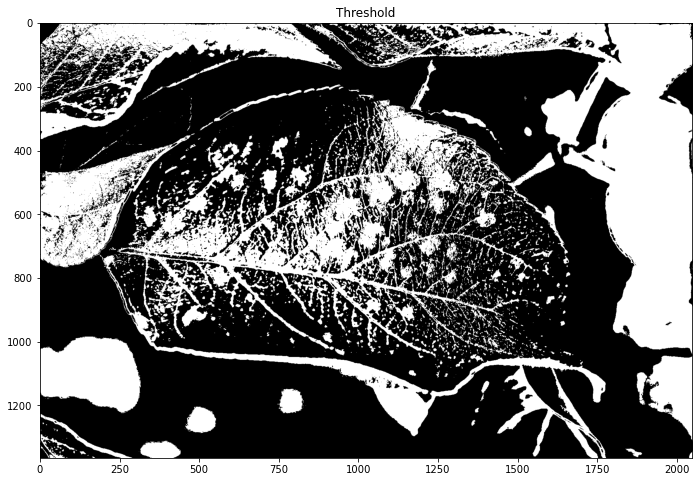

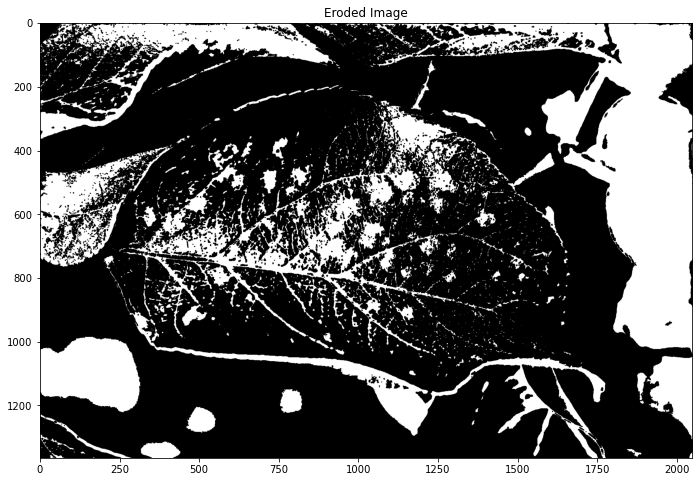

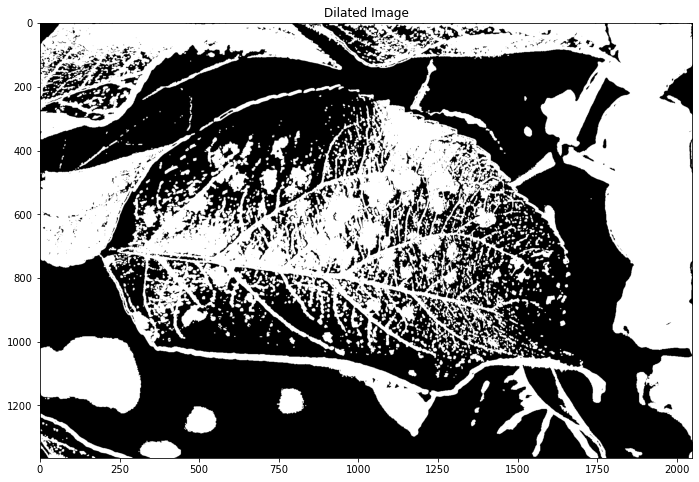

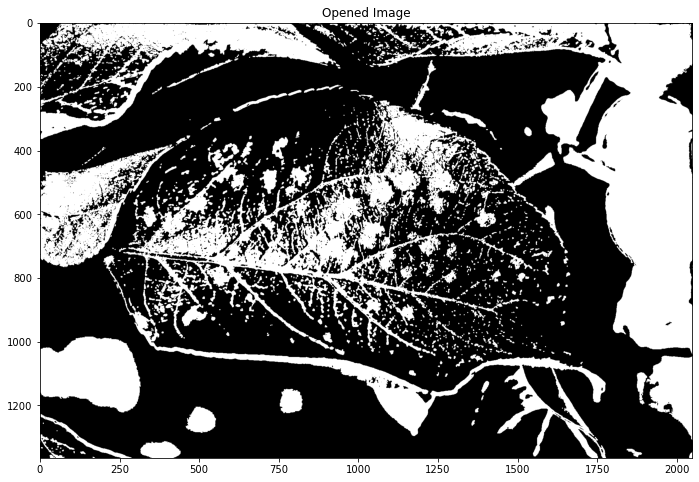

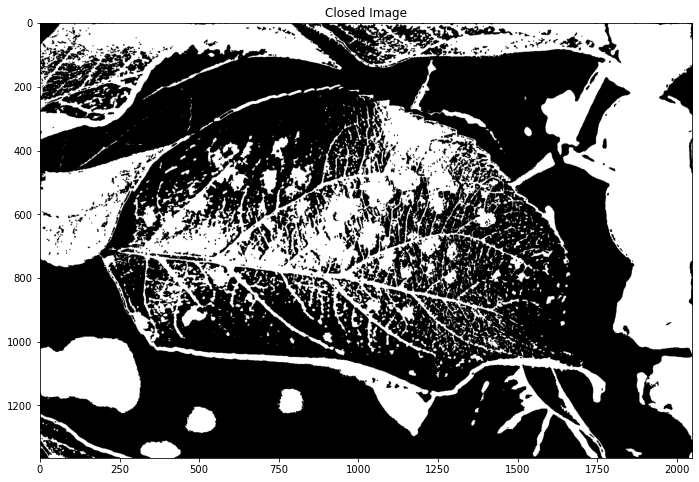

In [12]:
homo_filter = HomomorphicFilter(a = 0.98, b = 1)
homo_filtered = homo_filter.filter(I=train_images[0], filter_params=[30,2])

median = cv.medianBlur(homo_filtered,5)

_,th = cv.threshold(homo_filtered,0,255,cv.THRESH_BINARY+ cv.THRESH_OTSU)

plt.figure(figsize = (13,8))   
plt.title("Threshold")
plt.imshow(th,cmap = 'gray')
plt.show()

kernel = np.ones((3,3), np.uint8)
erosion = cv.erode(th,kernel, iterations = 1)
dilation = cv.dilate(th,kernel,iterations = 1)
opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(th, cv.MORPH_CLOSE, kernel)

plt.figure(figsize = (13,8))   
plt.title("Eroded Image")
plt.imshow(erosion,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Dilated Image")
plt.imshow(dilation,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Opened Image")
plt.imshow(opening,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Closed Image")
plt.imshow(closing,cmap = 'gray')
plt.show()